In [1]:
import numpy as np
from keras import backend as K
from keras.objectives import mean_squared_error
def log_poisson(y_true, log_y_pred):
    return K.mean(K.exp(log_y_pred) - y_true * log_y_pred, axis=-1)

def poi_gau_mix(y_true, log_y_pred):
    return log_poisson(y_true, log_y_pred) + 0.01*mean_squared_error(y_true, K.exp(log_y_pred))

Using Theano backend.


In [72]:
from tensorflow import python_io, train
import tensorflow as tf

In [19]:
# from keras.layers import Embedding, Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dense, Dropout, Activation, Embedding, Input
from keras.models import Model
from keras.constraints import MaxNorm
from keras.layers.advanced_activations import ELU

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM
from keras.regularizers import l2, l1l2

# create the model
inp_channels = 16
input_dim = 120001*inp_channels
# embed_dim = 128

print('Build model...')
mo = Sequential()
# mo.add(Embedding(input_dim, embed_dim, dropout=0.2))
# mo.add(Input(shape=(input_dim,)))
mo.add(Dense(1, input_shape=(input_dim,),  W_regularizer=l1l2(l1=0.01, l2=0.01)))
mo.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
mo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print(model.summary())
# # model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)

Build model...


In [6]:
filepath = "periodigram_lasso"
# mo.load_weights(filepath)

In [7]:
mo.optimizer.lr.set_value(.01)

In [8]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    if epoch == 15:
        mo.optimizer.lr.set_value(.01)
    if epoch == 20:
        mo.optimizer.lr.set_value(.005)
    return float(mo.optimizer.lr.get_value())

change_lr = LearningRateScheduler(scheduler)

In [92]:
from scipy.io import loadmat
import six
def mat_to_data(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    for kk,vv in six.iteritems(ndata):
#         print(vv.shape)
        if vv.shape == (1,1):
            ndata[kk] = vv[0,0]
    return ndata

def get_label(infile):
    return infile.split("/")[-1].split(".")[0][-1] == "0"


infile = "./data/1_1_0.mat"
data = mat_to_data(infile)
label = get_label(infile)

In [80]:
import os
from scipy import signal 
def filegen(folder, BATCH_SIZE = 64, xfun = lambda x: x):
    xx = []
    yy = []
    infiles = os.listdir(folder)
    NUM_FILES = len(infiles)
    for nn, ff in enumerate(infiles):
        label = get_label(ff)
        data = mat_to_data(infile)
        yield np.dstack(data["data"]).transpose(0,2,1), np.array([[label]])
#         yield  data["data"], np.array([[label]])
#         xx.append(data["data"])
#         yy.append(label)
#         if ((nn+1) % BATCH_SIZE == 0) or ((nn+1)==NUM_FILES):
#             data = np.dstack(xx).transpose(2,0,1)
#             label = np.array(yy)[:,np.newaxis,np.newaxis]
# #             print(data.shape, label.shape)
#             xx = []
#             yy = []
#             yield data, label

def periodigram_gen(folder, BATCH_SIZE):
    xlist = []
    ylist = []
    for nn, (xx, yy) in enumerate(filegen(folder, BATCH_SIZE = 1)):
        xx = xx[0]
        (freq, powspec) = signal.periodogram(xx.T)
        print(powspec.shape)
        xlist.append(powspec.T.ravel())
        ylist.append(yy)
#         print(((nn+1) % BATCH_SIZE == 0))
        if ((nn+1) % BATCH_SIZE == 0):
            yield np.vstack(xlist), np.vstack(ylist)
    
# datadir = "data/"
BATCH_SIZE = 1
gen = periodigram_gen(datadir, BATCH_SIZE=BATCH_SIZE)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '1_1_0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '1_1_1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '1_2_0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural n

<bound method HDFStore.close of <class 'pandas.io.pytables.HDFStore'>
File path: periodigrams.h5
/1_1_0            frame        (shape->[16,120001])
/1_1_1            frame        (shape->[16,120001])
/1_2_0            frame        (shape->[16,120001])
/1_2_1            frame        (shape->[16,120001])>

In [93]:
def read_periodigrams(h5filename = "data/periodigrams.h5"):
    h5 = HDFStore(h5filename)
    for kk in h5.keys():
        yy = get_label(kk)
        xx = h5[kk].as_matrix()
        yield xx, yy

for xx, yy in read_periodigrams(h5filename = "data/periodigrams.h5"):
    print(xx.shape, yy)

(16, 120001) True
(16, 120001) False
(16, 120001) True
(16, 120001) False


In [71]:
# proto_path = "periodigrams.protobuf"
# wr = python_io.TFRecordWriter(proto_path)
# for xx, yy, ff in periodigram_gen_one_name(datadir):
#     tf.train.Example(features=tf.train.Features(
#         feature={
#                 "periodogram":xx,
#                 "label": yy,
#                 "file": ff
#             }))
#     print(ff, xx.shape, yy.shape)

imdb example:

    X (25000 , 80)
      (num_samples, seq_len)
     
eeg:

    X (num_samples, seq_len, embedding_dim)

In [35]:
from itertools import cycle
datadir = "data/"
BATCH_SIZE = 4
gen = cycle(periodigram_gen(datadir, BATCH_SIZE = BATCH_SIZE))
# print(type(gen))
# print(gen.next())
mo.fit_generator(gen, nb_worker=1,
                 nb_epoch=10, samples_per_epoch = BATCH_SIZE,
                callbacks=[change_lr])

Epoch 1/10
4/4 [==============================] - 4s - loss: 20.0817 - acc: 0.5000
Epoch 2/10
4/4 [==============================] - 0s - loss: 19.1609 - acc: 0.5000
Epoch 3/10
4/4 [==============================] - 0s - loss: 19.3867 - acc: 0.5000
Epoch 4/10
4/4 [==============================] - 0s - loss: 16.9934 - acc: 0.5000
Epoch 5/10
4/4 [==============================] - 0s - loss: 18.4323 - acc: 0.5000
Epoch 6/10
4/4 [==============================] - 0s - loss: 20.8267 - acc: 0.5000
Epoch 7/10
4/4 [==============================] - 0s - loss: 20.5914 - acc: 0.5000
Epoch 8/10
4/4 [==============================] - 0s - loss: 20.7832 - acc: 0.5000
Epoch 9/10
4/4 [==============================] - 0s - loss: 21.7350 - acc: 0.5000
Epoch 10/10
4/4 [==============================] - 0s - loss: 20.7905 - acc: 0.5000


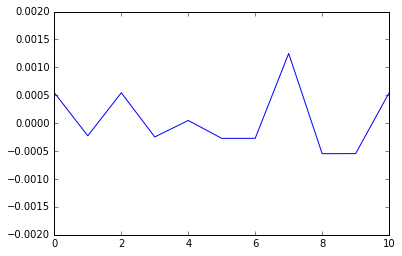

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
la = mo.layers[0]

plt.plot(la.get_weights()[0].reshape(inp_channels,-1)[0])
plt.xlim([0,10])
pass

In [50]:
la.get_weights()[0].reshape(inp_channels,-1)[0].shape

(120001,)